# 3D segmentation masks projection on 2D photo context image


### Introduction

Previously we have made a [tutorial](https://developer.supervisely.com/getting-started/python-sdk-tutorials/point-clouds/point-cloud-segmentation-with-2d-mask-guidance) on how to transfer segmentation masks from 2D photo context image to 3D point cloud. This time we will do the opposite - transfer segmentation masks from  3D point cloud to 2D photo context image.

In this tutorial, we will show an example of transfering segmention masks from 3D point cloud to 2D photo context image. Segmented image will be uploaded to Supervisely Platform - after that it is possible to export image segmentation masks in any popular format. We wil take point cloud, photo context image and camera calibration parameters from [KITTI](https://www.cvlibs.net/datasets/kitti/) dataset as an example, but this approach can be generalized to any data. Supervisely's [3D Point Cloud labeling tool](https://ecosystem.supervisely.com/annotation_tools/pointcloud-labeling-tool) and [Image labeling tool](https://ecosystem.supervisely.com/annotation_tools/image-labeling-tool-v2) will be used for working with point cloud and photo context image respectively.


### Input data overview: 3D point cloud with segmentation mask, photo context image, camera calibration parameters

Firstly, we will need 3D point cloud with segmentation mask:

![input point cloud](../tutorial_data/input_pcd.png)

Secondly, we will need 2D photo context image related to this point cloud:

![photo context](../tutorial_data/photo_context.png)

Finally, we will need camera calibration parameters to project LiDAR 3D points on 2D photo context image. KITTI dataset provides several sensor calibration files:

- calib_cam_to_cam.txt - contains matrices for camera-to-camera calibration
- calib_velo_to_cam.txt - contains matrices for velodyne-to-camera registration

File for camera-to-camera calibration contains the following data (source - [KITTI README](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT)):

- S_xx: 1x2 size of image xx before rectification
- K_xx: 3x3 calibration matrix of camera xx before rectification
- D_xx: 1x5 distortion vector of camera xx before rectification
- R_xx: 3x3 rotation matrix of camera xx (extrinsic)
- T_xx: 3x1 translation vector of camera xx (extrinsic)
- S_rect_xx: 1x2 size of image xx after rectification
- R_rect_xx: 3x3 rectifying rotation to make image planes co-planar
- P_rect_xx: 3x4 projection matrix after rectification

For our task, we will need only P_rect_xx, R_rect_xx, R_xx and T_xx matrices.

File for velodyne-to-camera registration contains the following data:

- R: 3x3 rotation matrix
- T: 3x1 translation vector

This data serves as a representation of the velodyne coordinate frame in camera coordinates. We will need rotation matrix and translation vector in order to transform point in velodyne coordinates into the camera coordinate system.

### Environment preparation and libraries import

For running the code provided in this tutorial, you will need some Python modules: `supervisely`, `open3d` and `alphashape`. You can use [this Dockerfile](https://github.com/supervisely-ecosystem/3d-mask-projection/blob/master/.devcontainer/Dockerfile) for convenience:

```docker
FROM supervisely/base-py-sdk:6.73.45

RUN pip3 install open3d==0.13.0
RUN pip3 install executing==1.1.1
RUN pip3 install jsonschema==4.20.0
RUN pip3 install alphashape==1.3.1
RUN pip3 install python-json-logger==2.0.2
```

Import necessary libraries, load [Supervisely account credentials](https://developer.supervisely.com/getting-started/basics-of-authentication) and set image display parameters:

In [6]:
# import necessary libraries
import supervisely as sly
from dotenv import load_dotenv
from PIL import Image
import os
import matplotlib.pyplot as plt
import open3d as o3d
import json
import numpy as np
import cv2
import alphashape
from matplotlib import cm


# load credentials
load_dotenv("../supervisely.env")
api = sly.Api()

# define input parameters
pcd_id = 316219
photo_context_image_path = "../tutorial_data/photo_context.png"
cam_to_cam_file_path = "../tutorial_data/calib_cam_to_cam.txt"
velo_to_cam_file_path = "../tutorial_data/calib_velo_to_cam.txt"


# set image display parameters
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### Download input point cloud and its annotation

In [7]:
# download input point cloud to local storage
save_dir = "../tutorial_data/"
local_pcd_path = os.path.join(save_dir, "lidar_data.pcd")
api.pointcloud.download_path(pcd_id, local_pcd_path)

# download point cloud mask created with pen tool
ann_info = api.pointcloud.annotation.download(pcd_id)
mask_indexes = ann_info["figures"][0]["geometry"]["indices"]

### Get sensor calibration parameters

We already [covered](https://developer.supervisely.com/getting-started/python-sdk-tutorials/point-clouds/point-cloud-segmentation-with-2d-mask-guidance#get-sensor-calibration-parameters) the topic of sensor calibration parameters in our previous tutorial, but we will also duplicate it here for convenience.

The KITTI [paper](https://www.cvlibs.net/publications/Geiger2013IJRR.pdf) describes the transformation from LiDAR to camera $i$ as follows, where each transformation matrix has been converted to it's homogeneous representation. The difference here is that we have changed the notation and added the transformation to the desired camera reference.

$$ \tilde{y} = P^{cam_i}_{rect_i} R^{rect_i}_{ref_i} T^{ref_i}_{ref0} T^{ref0}_{velo} \tilde{x},
  \qquad \text{where } \tilde{x} = [x, y, z, 1]^T $$

$$ \tilde{y} = \left( \tilde{u}, \tilde{v}, z, 1 \right) $$

For convenience we will denote the transformation from LiDAR to Camera $i$ like Isaac Berrios [proposed](https://github.com/itberrios/CV_tracking/blob/main/kitti_tracker/1_kitti_object_detection_lidar.ipynb) in his sensor fusion tutorial:

$$ T^{cam_i}_{velo} = P^{cam_i}_{rect_i} R^{rect_i}_{ref_i} T^{ref_i}_{ref0} T^{ref0}_{velo} $$

Where 
- $T^{ref}_{velo}$ - LiDAR to Camera Reference &rarr; transforms a 3D point relative to the LiDAR to a 3D point relative to the Camera
- $T^{ref_i}_{ref0}$ - Rigid Body Transformation from Camera 0 to Camera $i$
- $R^{rect_i}_{ref_i}$ - Camera $i$ to Rectified Camera $i$ reference 
- $P^{cam_i}_{rect_i}$ - Rectified Camera $i$ to 2D Camera $i$ $(u,v,z)$ coodinate space
- $T^{cam_i}_{velo}$ - 3D LiDAR space to 2D Camera $i$ $(u,v,z)$ coordinate space.

Where $(u,v,z)$ are the final camera coordinates after the rectification and projection transforms. In order to transform from homogeneous image coordinates $\tilde{y}$ to true $(u, v, z)$ image coordinates y, we will need to normalize by the depth and drop the 1:

$$ y = \left( \frac{\tilde{u}}{z}, \frac{\tilde{v}}{z}, z \right) $$

In [8]:
# define target camera number
camera_number = 2

# read calib_cam_to_cam.txt
calib_cam_to_cam_file = open(cam_to_cam_file_path)
calib_cam_to_cam_dict = {}
for line in calib_cam_to_cam_file.readlines():
    key, value = line.split(": ")
    calib_cam_to_cam_dict[key] = value.strip()
calib_cam_to_cam_file.close()

# read calib_velo_to_cam.txt
calib_velo_to_cam_file = open(velo_to_cam_file_path)
calib_velo_to_cam_dict = {}
for line in calib_velo_to_cam_file.readlines():
    key, value = line.split(": ")
    calib_velo_to_cam_dict[key] = value.strip()
calib_velo_to_cam_file.close()

In [9]:
# get projection matrices
P_rect = calib_cam_to_cam_dict[f"P_rect_0{camera_number}"]
P_rect = np.array([float(x) for x in P_rect.split(" ")]).reshape(
    (3, 4)
)
P_rect

array([[ 7.188560e+02,  0.000000e+00,  6.071928e+02,  4.538225e+01],
       [ 0.000000e+00,  7.188560e+02,  1.852157e+02, -1.130887e-01],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  3.779761e-03]])

In [10]:
# get rectified rotation matrices
R_rect = calib_cam_to_cam_dict[f"R_rect_0{camera_number}"]
R_rect = np.array([float(x) for x in R_rect.split(" ")]).reshape(
    (3, 3)
)
# add (0, 0, 0) translation and convert to homogeneous coordinates
R_rect = np.insert(R_rect, 3, values=[0, 0, 0], axis=0)
R_rect = np.insert(R_rect, 3, values=[0, 0, 0, 1], axis=1)
R_rect

array([[ 9.999191e-01,  1.228161e-02, -3.316013e-03,  0.000000e+00],
       [-1.228209e-02,  9.999246e-01, -1.245511e-04,  0.000000e+00],
       [ 3.314233e-03,  1.652686e-04,  9.999945e-01,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [11]:
# get rotation matrix from reference camera to target camera
R = calib_cam_to_cam_dict[f"R_0{camera_number}"]
R = np.array([float(x) for x in R.split(" ")]).reshape((3, 3))
# get translation vector from reference camera to target camera
t = calib_cam_to_cam_dict[f"T_0{camera_number}"]
t = np.array([float(x) for x in t.split(" ")]).reshape((3, 1))
# get reference camera to target camera rigid body transformation in homogeneous coordinates
T_ref_to_target = np.insert(np.hstack((R, t)), 3, values=[0, 0, 0, 1], axis=0)
T_ref_to_target

array([[ 9.999788e-01, -5.008404e-03, -4.151018e-03,  5.954406e-02],
       [ 4.990516e-03,  9.999783e-01, -4.308488e-03, -7.675338e-04],
       [ 4.172506e-03,  4.287682e-03,  9.999821e-01,  3.582565e-03],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [12]:
# get lidar to camera reference transformation
R_velo = np.array([float(x) for x in calib_velo_to_cam_dict["R"].split(" ")]).reshape((3, 3))
t_velo = np.array([float(x) for x in calib_velo_to_cam_dict["T"].split(" ")])[:, None]
T_velo_ref0 = np.vstack((np.hstack((R_velo, t_velo)), np.array([0, 0, 0, 1])))
T_velo_ref0

array([[ 7.967514e-03, -9.999679e-01, -8.462264e-04, -1.377769e-02],
       [-2.771053e-03,  8.241710e-04, -9.999958e-01, -5.542117e-02],
       [ 9.999644e-01,  7.969825e-03, -2.764397e-03, -2.918589e-01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

### Project LiDAR 3D points on 2D photo context image

Next step - project LiDAR 3D points on photo context image and get projections of points which belong to segmented area in point cloud (mask projections).

In [13]:
# transform from velo (LiDAR) to target camera
T_velo_to_cam = P_rect @ R_rect @ T_ref_to_target @ T_velo_ref0
T_velo_to_cam

array([[ 6.07484390e+02, -7.18537361e+02, -1.01875822e+01,
        -9.55729189e+01],
       [ 1.80027463e+02,  5.89922104e+00, -7.20148711e+02,
        -9.34570810e+01],
       [ 9.99973895e-01,  4.85949260e-04, -7.20693419e-03,
        -2.84637351e-01]])

In [14]:
# get lidar points
pcd = o3d.io.read_point_cloud(local_pcd_path, format="pcd")
pcd_points = np.asarray(pcd.points)
xyzw = np.insert(pcd_points, 3, 1, axis=1).T
xyzw

array([[70.12200165, 69.74500275, 68.9509964 , ...,  3.76300001,
         3.7809999 ,  3.77699995],
       [37.46500015, 37.54600143, 37.39799881, ..., -1.42400002,
        -1.41700006, -1.40900004],
       [ 2.89700007,  2.88800001,  2.86199999, ..., -1.75999999,
        -1.76699996, -1.76400006],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [15]:
# get 3D points projections on photo context image
projections = T_velo_to_cam @ xyzw
projections[:2] /= projections[2, :]
projections

array([[222.71653185, 219.79103526, 216.86000628, ..., 925.86836546,
        922.80742564, 921.52290694],
       [152.7242648 , 152.67601167, 152.61939769, ..., 528.05500769,
        527.71001796, 527.50650563],
       [ 69.83286137,  69.45597654,  68.66210638, ...,   3.49025664,
          3.50830991,   3.50429233]])

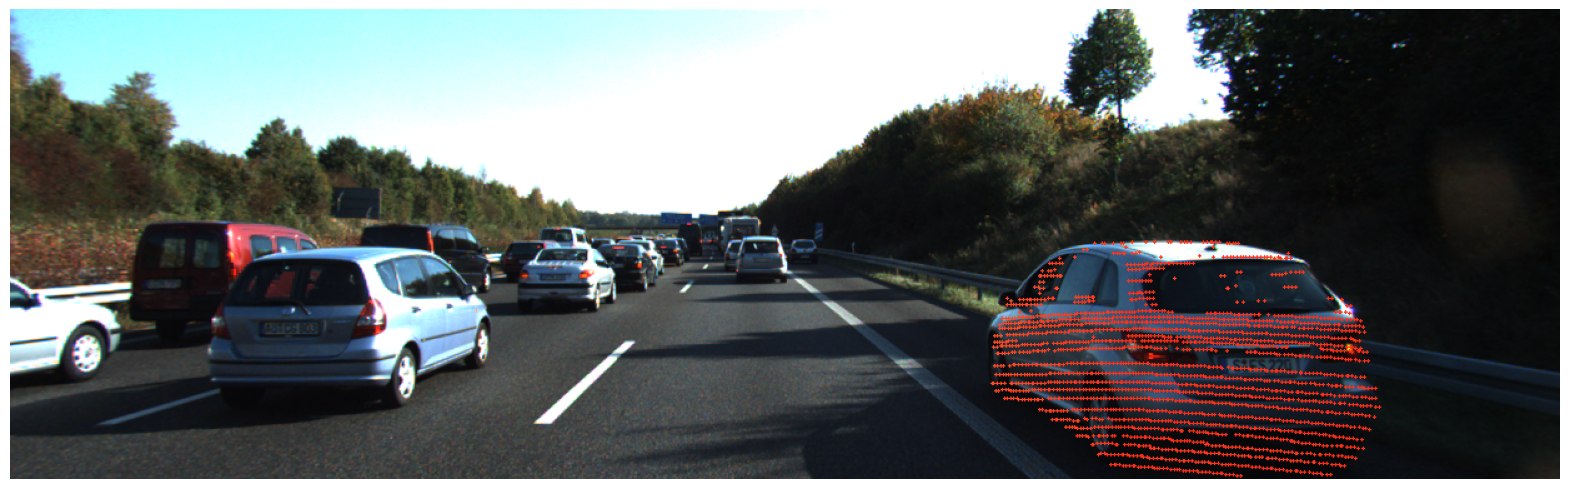

In [16]:
def draw_projections_on_image(velo_uvz, image, save_path, preprocess=True, indexes=None):
    """Draw LiDAR point projectiins on the image"""
    if preprocess:
        # remove negative points
        velo_uvz = np.delete(velo_uvz, np.where(velo_uvz[2, :] < 0)[0], axis=1)

        # remove outliers
        u, v, z = velo_uvz
        img_h, img_w, _ = image.shape
        u_out = np.logical_or(u < 0, u > img_w)
        v_out = np.logical_or(v < 0, v > img_h)
        outliers = np.logical_or(u_out, v_out)
        velo_uvz = np.delete(velo_uvz, np.where(outliers), axis=1)

    # create color map
    u, v, z = velo_uvz
    rainbow_r = cm.get_cmap("rainbow_r", lut=100)
    color_map = lambda z: [255 * val for val in rainbow_r(int(z.round()))[:3]]

    # draw LiDAR point cloud on blank image
    for i in range(len(u)):
        if indexes and i in indexes:
            cv2.circle(image, (int(u[i]), int(v[i])), 1, color_map(z[i]), -1)

    if indexes:
        for i in indexes:
            cv2.circle(image, (int(u[i]), int(v[i])), 1, color_map(z[i]), -1)
    else:
        for i in range(len(u)):
            cv2.circle(image, (int(u[i]), int(v[i])), 1, color_map(z[i]), -1)

    # save result
    image = Image.fromarray(image)
    image.save(save_path)


# get projections of masked points
mask_projections = projections.T[mask_indexes].T

# read photo context image
photo_context_image = sly.image.read(photo_context_image_path)

# draw point projections on image and display result
save_path = os.path.join(save_dir, "projections.png")
draw_projections_on_image(mask_projections.copy(), photo_context_image.copy(), save_path)
plt.axis("off")
plt.imshow(Image.open(save_path));

### Build 2D segmentation mask from 3D point projections

In order to create segmentation mask from 3D point projections, we are going to build a convex hull - the smallest convex set that encloses all the points, forming a convex polygon. We found alphashape implementation of convex hull to be the most effective, but it is also possible to use cv2 and scipy convex hull implementations.

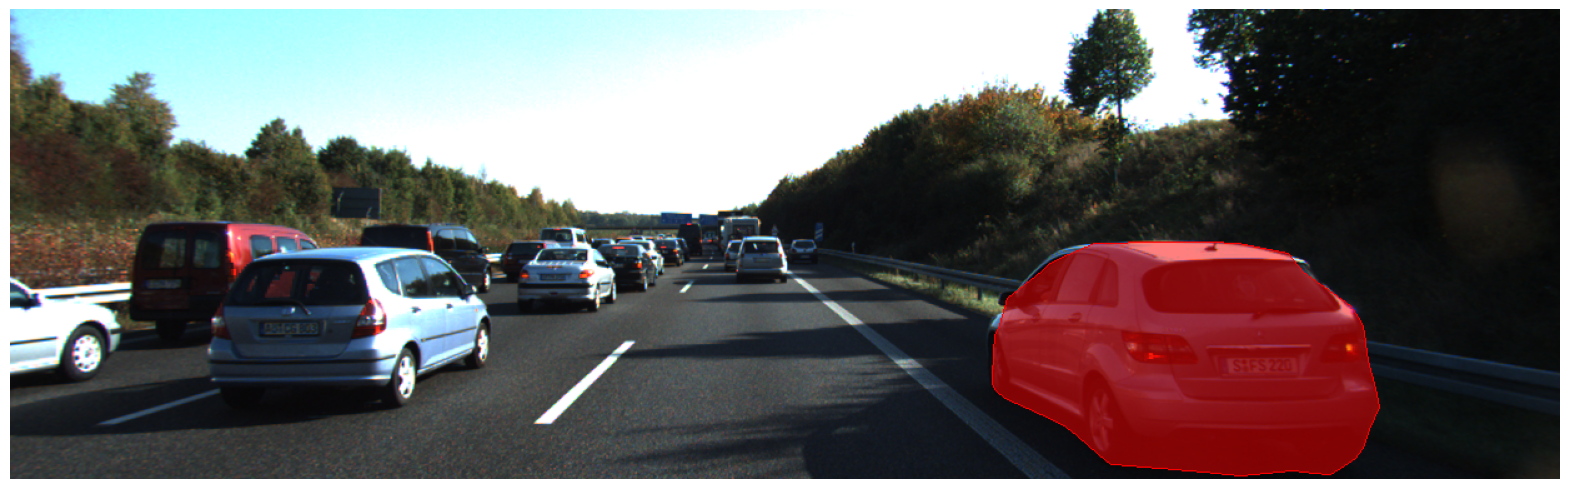

In [17]:
# build convex hull
convex_hull = alphashape.alphashape(mask_projections.T[:, :2], alpha=0.01) # alpha parameter needs to be tuned
if convex_hull.type == "Polygon":
    vertices = np.array(list(zip(*convex_hull.exterior.coords.xy)))
elif convex_hull.type == "MultiPolygon":
    vertices = []
    for geom in convex_hull.geoms:
        vertices.extend(list(zip(*geom.exterior.coords.xy)))
    vertices = np.array(vertices)
# create segmentation mask based on convex hull
bitmap = np.zeros(photo_context_image.shape[:2], np.uint8)
bitmap = cv2.drawContours(bitmap, [vertices.astype(int)], -1, 1, cv2.FILLED)
mask = bitmap == 1
# generate supervisely annotation and visualize result
sly_mask = sly.Bitmap(mask)
obj_class = sly.ObjClass("car", sly.Bitmap)
label = sly.Label(sly_mask, obj_class)
img_height, img_width = photo_context_image.shape[:2]
sly_ann = sly.Annotation(img_size=[img_height, img_width], labels=[label])
viz_img = photo_context_image.copy()
sly_ann.draw_pretty(viz_img, thickness=1, color=[255, 0, 0])
plt.axis("off")
plt.imshow(Image.fromarray(viz_img));

### Upload image and its mask annotation to Supervisely platform

Final step - upload result to Supervisely platform - it will create opportunities for convenient export of segmention masks and other data operations.

You will need team and workspace IDs.

Here is how to get your team ID:

![team id 0](../tutorial_data/team_id_0.png)

![team id 1](../tutorial_data/team_id_1.png)

Here is how to get your workspace ID:

![workspace id 0](../tutorial_data/workspace_id_0.png)

![workspace id 1](../tutorial_data/workspace_id_1.png)

In [18]:
# define team and workspace IDs
team_id = 4
workspace_id = 23
# create output images project
project = api.project.create(workspace_id, "Photo context with masks", change_name_if_conflict=True)
dataset = api.dataset.create(project.id, "ds_0", change_name_if_conflict=True)
# upload image to the platform
image_info = api.image.upload_path(
    dataset.id,
    name="photo_context.jpg",
    path=photo_context_image_path,
)
# add previously created plant object class to project meta
project_meta = sly.ProjectMeta(obj_classes=[obj_class])
api.project.update_meta(project.id, project_meta.to_json())
# upload mask annotation to the platform
api.annotation.upload_ann(image_info.id, sly_ann)

Result:

![result](../tutorial_data/result.png)